## Example 1: Hillstrom Email Experiment  
### Applying DAG + variable roles + GOOD vs BAD causal estimates (mediator & collider)


### Dataset Description (Hillstrom Email Campaign)

#### Source and relevance to causality
This worked example uses the **Hillstrom “MineThatData” Email Analytics Challenge** dataset, a classic benchmark for uplift modeling and causal analysis in marketing. Customers were **randomly assigned** to one of three groups: **Mens E-Mail**, **Womens E-Mail**, or **No E-Mail (control)**. Because treatment assignment is randomized, baseline customer characteristics should be balanced across groups, allowing simple group comparisons to be interpreted causally (under standard assumptions like SUTVA).

In this notebook, we focus on a binary contrast (**Mens E-Mail vs No E-Mail**) to match the propensity score/IPW workflow used in Part 1 and to make the mediator/selection pitfalls easy to demonstrate.

#### Key variables and causal relationships
- **Treatment (`T`)**: indicator for receiving the *Mens E-Mail* (1) vs *No E-Mail* (0).
- **Outcome (`Y`)**: `spend`, the amount spent during the outcome window (many customers spend 0, which is expected in retail).
- **Pre-treatment covariates (baseline customer attributes)**:  
  `recency`, `history`, `history_segment`, `mens`, `womens`, `zip_code`, `newbie`, `channel`.  
  These are measured before the email is sent and can be used as adjustment variables (even though randomization already balances them on average).
- **Post-treatment mediator**: `visit` (email can increase site visits, which can increase spend).
- **Post-treatment selection risk**: `conversion` (conditioning on converters changes the analyzed population; it is affected by treatment and related to spending).

Conceptually, the causal structure can be summarized as:
- Baseline covariates influence purchasing propensity (`X → Y`) and may also relate to email engagement (`X → visit/conversion`).
- The email can affect spend directly (`T → Y`) and indirectly via visiting behavior (`T → visit → Y`).
- Conditioning on post-treatment variables like `visit` or selecting only converters can change the estimand or introduce selection bias.


### Problem Setup

#### Causal question (hypothesis)
**Primary causal question:**  
What is the **average causal effect** of sending the **Mens E-Mail** campaign (vs sending **no email**) on customer **spending** during the outcome window?

Equivalently, we aim to estimate the Average Treatment Effect (ATE):
$$
ATE = \mathbb{E}[Y(1) - Y(0)]
$$
where \(Y(1)\) is the potential spend if a customer receives the Mens email and \(Y(0)\) is the potential spend if they receive no email.

#### Treatment, outcome, and adjustment variables
- **Treatment (`T`)**: binary indicator  
  - `T = 1` if `treatment == "Mens E-Mail"`  
  - `T = 0` if `treatment == "No E-Mail"`

- **Outcome (`Y`)**: `spend` (numeric)

- **Potential confounders / pre-treatment covariates (`X`)**: baseline attributes measured before treatment assignment  
  `recency`, `history`, `history_segment`, `mens`, `womens`, `zip_code`, `newbie`, `channel`  
  In a randomized experiment these should be balanced by design, but we still treat them as the *valid adjustment set* when replicating the propensity score/IPW workflow from Part 1 and when running balance diagnostics.

- **Variables not to adjust for when estimating the total effect** (post-treatment):
  - **Mediator:** `visit` (blocks part of the pathway $T \rightarrow visit \rightarrow spend$ if conditioned on)
  - **Selection risk:** `conversion` (restricting analysis to converters conditions on a post-treatment variable and can distort causal conclusions)

#### Identification assumption 
Because assignment to email vs no email is randomized, the simple treated–control difference in mean spend provides a causal benchmark for the total effect (subject to standard assumptions like SUTVA).
**Causal assumptions:** (i) random assignment of email group, (ii) SUTVA/no interference between customers, and (iii) positivity/overlap (supported by the overlap and weight diagnostics).



#### Import all the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from graphviz import Digraph


#### Loading the dataset

In [3]:
from sklift.datasets import fetch_hillstrom
import pandas as pd

dataset = fetch_hillstrom(target_col="all")

X = dataset.data.copy()
y = dataset.target.copy()
treat = dataset.treatment  # <- this is the key you need

df = X.copy()
df["visit"] = y["visit"].values
df["conversion"] = y["conversion"].values
df["spend"] = y["spend"].values
df["treatment"] = pd.Series(treat).values

df.head()


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,visit,conversion,spend,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,0,0,0.0,Womens E-Mail
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,0,0,0.0,No E-Mail
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,0,0,0.0,Womens E-Mail
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,0,0,0.0,Mens E-Mail
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,0,0,0.0,Womens E-Mail


#### Filter to Mens vs Control; create `T` (0/1) and `Y=spend`.

In [4]:

# Use your existing df with columns already created
df2 = df[df["treatment"].isin(["Mens E-Mail", "No E-Mail"])].copy()
df2["T"] = (df2["treatment"] == "Mens E-Mail").astype(int)
df2["Y"] = df2["spend"]

df2[["treatment","T","Y","visit","conversion"]].head()



,treatment,T,Y,visit,conversion
1,No E-Mail,0,0.0,0,0
3,Mens E-Mail,1,0.0,0,0
8,Mens E-Mail,1,0.0,0,0
13,Mens E-Mail,1,0.0,1,0
14,No E-Mail,0,0.0,0,0


Mapping is correct (`Mens E-Mail`→1, `No E-Mail`→0). Many `spend=0` is normal. `visit`/`conversion` are post-treatment.

#### Define variable roles (treatment, outcome, confounders to adjust for, and post-treatment variables to avoid) and print them for clarity.

In [5]:
treatment_col = "T"
outcome_col = "Y"

confounders = ["recency", "history", "history_segment", "mens", "womens", "zip_code", "newbie", "channel"]
mediators = ["visit"]
colliders = ["conversion"]

print("Treatment:", treatment_col)
print("Outcome:", outcome_col)
print("Adjust (confounders):", confounders)
print("Do NOT adjust (mediators/colliders):", mediators + colliders)


Treatment: T
Outcome: Y
Adjust (confounders): ['recency', 'history', 'history_segment', 'mens', 'womens', 'zip_code', 'newbie', 'channel']
Do NOT adjust (mediators/colliders): ['visit', 'conversion']


#### Draw the assumed **causal DAG** showing: pre-treatment covariates → treatment/outcome, treatment → outcome, and post-treatment variables (`visit`, `conversion`) that can create bias if conditioned on.


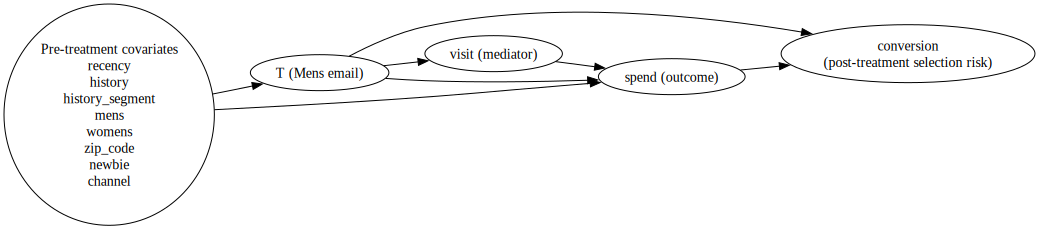

In [6]:
cov_text = "Pre-treatment covariates\n" + "\n".join(confounders)

dot = Digraph(graph_attr={"rankdir":"LR"})
dot.node("X", cov_text)
dot.node("T", "T (Mens email)")
dot.node("V", "visit (mediator)")
dot.node("Y", "spend (outcome)")
dot.node("C", "conversion\n(post-treatment selection risk)")

dot.edges([
    ("X","T"), ("X","Y"),
    ("T","V"), ("V","Y"),
    ("T","Y"),
    ("T","C"), ("Y","C")
])
dot
#`visit` and `conversion` are measured after the email assignment, so they are treated as post-treatment variables.

#### Compute the **benchmark causal effect** using the treated–control difference in mean spend (valid here because assignment is randomized).


In [17]:
ate_benchmark = df2.loc[df2["T"]==1, "Y"].mean() - df2.loc[df2["T"]==0, "Y"].mean()
print("Benchmark ATE (randomized diff-in-means):", ate_benchmark)


Benchmark ATE (randomized diff-in-means): 0.7698271558945367


The estimated ATE is **~0.77**: on average, sending the Mens email increases spend by about **0.77 units** versus no email in this sample.

#### Why use propensity/IPW here?
Because treatment is randomized, the treated–control difference in mean spend is already a causal benchmark. We still run the propensity/IPW workflow to (i) mirror the Part 1 methodology, (ii) demonstrate overlap and balance diagnostics on real data, and (iii) show concretely how post-treatment adjustment (mediator/selection) can distort causal conclusions.


#### Build a preprocessing + logistic regression pipeline to estimate propensity scores using **pre-treatment covariates only** (impute missing values, one-hot encode categoricals, then fit `P(T=1 | X)`).


In [18]:
num_cols = ["recency", "history", "mens", "womens"]
cat_cols = ["history_segment", "zip_code", "newbie", "channel"]

good_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median", add_indicator=True))
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols),
    ],
    remainder="drop"
)

ps_model = Pipeline(steps=[
    ("prep", good_preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])


Logistic regression estimates each unit’s propensity score \(e(X)=P(T=1 \mid X)\), which is then used to construct IPW weights that balance covariates between treated and control groups.


#### Helper Functions from Causality_Notebook.ipynb

- `compute_smd(...)` checks **covariate balance** between treated and control (before/after weighting).
- `ipw_ate(...)` computes the **IPW estimate of ATE** and returns the **weights** used.
- `plot_overlap(...)` visualizes **propensity score overlap/positivity** between groups.


In [9]:
#Standardized mean difference 
def compute_smd(df_in, t_col, feature_cols, weights=None):
    """
    Standardized Mean Difference (SMD) for each feature.
    For categorical features, assumes they are already one-hot encoded in df_in.
    """
    t = df_in[t_col].values
    w = np.ones(len(df_in)) if weights is None else np.asarray(weights)

    smd = {}
    for col in feature_cols:
        x = df_in[col].values

        w1 = w[t == 1]
        w0 = w[t == 0]
        x1 = x[t == 1]
        x0 = x[t == 0]

        m1 = np.average(x1, weights=w1)
        m0 = np.average(x0, weights=w0)
        v1 = np.average((x1 - m1) ** 2, weights=w1)
        v0 = np.average((x0 - m0) ** 2, weights=w0)
        denom = np.sqrt(0.5 * (v1 + v0)) + 1e-12
        smd[col] = (m1 - m0) / denom

    return pd.Series(smd).sort_values(key=lambda s: np.abs(s), ascending=False)

#Inverse probability Weighting
def ipw_ate(df_in, t_col, y_col, e_hat, stabilize=False):
    """
    IPW estimate of ATE.
    If stabilize=True, use stabilized weights to reduce variance.
    """
    t = df_in[t_col].values
    y = df_in[y_col].values
    e = np.clip(e_hat, 1e-4, 1 - 1e-4)

    if stabilize:
        pt = t.mean()
        w = np.where(t == 1, pt / e, (1 - pt) / (1 - e))
    else:
        w = np.where(t == 1, 1 / e, 1 / (1 - e))

    mu1 = np.average(y[t == 1], weights=w[t == 1])
    mu0 = np.average(y[t == 0], weights=w[t == 0])
    ATE = mu1 - mu0
    return (mu1 - mu0), w


def plot_overlap(e_hat, t, title):
    plt.figure()
    plt.hist(e_hat[t == 1], bins=30, alpha=0.7, label="T=1")
    plt.hist(e_hat[t == 0], bins=30, alpha=0.7, label="T=0")
    plt.xlabel("Estimated propensity score e(X)")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.show()


#### Fit the propensity score model using **pre-treatment covariates only**, plot **propensity score overlap** (positivity check), and compute the **IPW ATE** using stabilized weights.


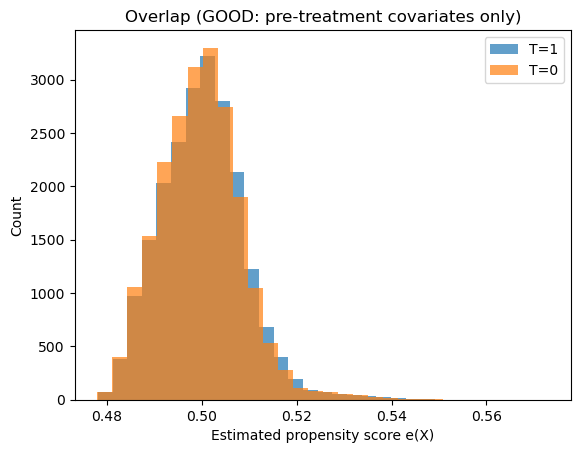

GOOD IPW ATE: 0.7660573529194609


In [10]:
X_good = df2[confounders]
t = df2["T"].values

ps_model.fit(X_good, t)
e_good = ps_model.predict_proba(X_good)[:, 1]

plot_overlap(e_good, t, "Overlap (GOOD: pre-treatment covariates only)")

ate_good, w_good = ipw_ate(df2, "T", "Y", e_good, stabilize=True)
print("GOOD IPW ATE:", ate_good)


The overlap plot shows strong overlap between `T=1` and `T=0` with propensities tightly centered around ~0.5, which is consistent with randomized assignment (covariates shouldn’t predict treatment). The GOOD IPW ATE is **~0.766**, which closely matches the benchmark ATE (~0.770), so the causal-aware pipeline is behaving as expected.

Summarize the stabilized IPW weight distribution to ensure the estimate is not driven by extreme weights (a positivity/stability check).


In [11]:
print(pd.Series(w_good).describe(percentiles=[0.5, 0.9, 0.95, 0.99]))
print("Max weight:", np.max(w_good))


count    42613.000000
mean         1.000000
std          0.017598
min          0.876082
50%          0.999640
90%          1.021760
95%          1.028077
99%          1.040844
max          1.171018
dtype: float64
Max weight: 1.1710184215334576


Weights are extremely well-behaved: mean ≈ 1.0, 99% ≤ 1.041, and max ≈ 1.17. This indicates excellent overlap and high stability, consistent with randomized assignment (no observations are being heavily upweighted).

Preprocess covariates into a numeric design matrix (impute + one-hot encode), then compute **SMD balance diagnostics** before and after IPW to verify covariate balance.


In [12]:
# Fit + transform
Z = good_preprocess.fit_transform(df2[confounders])

# Get the exact feature names produced by the preprocessing
all_features = list(good_preprocess.get_feature_names_out())

# Build dataframe with correct dimensions
Z_df = pd.DataFrame(Z, columns=all_features)
Z_df["T"] = df2["T"].values

# Balance
smd_before = compute_smd(Z_df, "T", all_features)
smd_after  = compute_smd(Z_df, "T", all_features, weights=w_good)

balance = pd.DataFrame({"SMD_before": smd_before, "SMD_after_IPW": smd_after})
display(balance.head(15))
print("Max |SMD| before:", smd_before.abs().max())
print("Max |SMD| after:", smd_after.abs().max())


,SMD_before,SMD_after_IPW
cat__channel_Multichannel,-0.004182,0.000080
cat__channel_Phone,-0.008276,0.000051
cat__channel_Web,0.011014,-0.000104
cat__history_segment_1) $0 - $100,0.010917,0.000040
cat__history_segment_2) $100 - $200,-0.016360,0.000177
cat__history_segment_3) $200 - $350,0.005471,0.000024
cat__history_segment_4) $350 - $500,-0.004258,0.000287
cat__history_segment_5) $500 - $750,-0.009740,0.000230
"cat__history_segment_6) $750 - $1,000",0.006073,-0.001575
"cat__history_segment_7) $1,000 +",0.015835,0.000128


Max |SMD| before: 0.016359927097032125
Max |SMD| after: 0.0015747459386826015


Balance is already excellent (Max |SMD| ≈ **0.016**), which is what we expect under random assignment. After IPW, SMDs shrink even closer to 0, confirming treated/control are effectively balanced on these pre-treatment covariates.

#### Run a robustness check by trimming extreme propensity scores (keep only 0.05 ≤ e(X) ≤ 0.95) and recomputing the IPW ATE.

In [13]:
trim_low, trim_high = 0.05, 0.95
keep = (e_good >= trim_low) & (e_good <= trim_high)

trim_df = df2.loc[keep].copy()
trim_e = e_good[keep]

ate_trim, w_trim = ipw_ate(trim_df, "T", "Y", trim_e, stabilize=True)

print("Trimmed IPW ATE:", ate_trim)
print("Kept fraction:", keep.mean())


Trimmed IPW ATE: 0.7660573529194609
Kept fraction: 1.0


#### This cell intentionally violates the “adjust only for pre-treatment covariates” rule to demonstrate *why* causal feature selection matters. We add `visit` to the propensity score model:

- **GOOD design:** estimate \( e(X)=P(T=1 \mid X) \) using only baseline covariates measured before the email is sent.
- **BAD design (this cell):** estimate \( e(X, visit)=P(T=1 \mid X, visit) \), where `visit` occurs after treatment and is affected by it.

We then:
1. Fit the logistic regression propensity model using `confounders + visit`.
2. Plot the overlap (positivity) of estimated propensity scores for treated vs control.
3. Compute the IPW ATE using stabilized weights.


BAD IPW ATE (mediator included): 0.23996179435649312


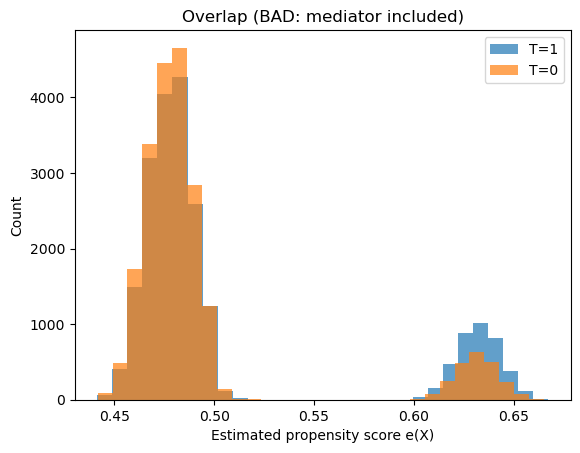

In [14]:
badA_features = confounders + ["visit"]

badA_preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median", add_indicator=True))]),
         ["recency", "history", "mens", "womens", "visit"]),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))]),
         cat_cols),
    ],
    remainder="drop"
)

badA_model = Pipeline(steps=[("prep", badA_preprocess),
                             ("clf", LogisticRegression(max_iter=2000))])

badA_model.fit(df2[badA_features], t)
e_badA = badA_model.predict_proba(df2[badA_features])[:, 1]

ate_badA, w_badA = ipw_ate(df2, "T", "Y", e_badA, stabilize=True)
print("BAD IPW ATE (mediator included):", ate_badA)
plot_overlap(e_badA, t, "Overlap (BAD: mediator included)")


#### Output interpretation 
**1) Overlap plot**
The plot shows two clear clusters rather than a single overlapping distribution. This happens because `visit` is strongly related to receiving an email (emails change the probability of visiting). Once we include `visit` in the model, the propensity scores partially reflect *post-treatment behavior* instead of only baseline comparability. This is a red flag: the “propensity score” is no longer describing selection into treatment based on pre-treatment factors.

**2) ATE drops from ~0.77 to ~0.24**
In the Hillstrom setting, a natural causal pathway is:
\[
T \rightarrow visit \rightarrow spend
\]
Including the mediator `visit` in the adjustment/weighting process effectively removes (or attenuates) the part of the treatment effect that operates through visits. As a result, the estimated effect shrinks substantially.

**Key takeaway**
This is not “just a statistical artifact.” It is a concrete demonstration of causal reasoning:
- If the estimand is the **total effect** of the email on spend, `visit` should **not** be adjusted for.
- Conditioning on or adjusting for a mediator changes the question to something closer to a **direct-effect-like** quantity and can lead to misleading conclusions if interpreted as the total effect.


#### Create a **bad analysis** by filtering to `conversion==1` (post-treatment selection), then re-estimate the effect using the same propensity/IPW workflow.


In [15]:
badB_df = df2[df2["conversion"] == 1].copy()

ps_model.fit(badB_df[confounders], badB_df["T"].values)
e_badB = ps_model.predict_proba(badB_df[confounders])[:, 1]
ate_badB, _ = ipw_ate(badB_df, "T", "Y", e_badB, stabilize=True)

print("BAD estimate (converters only selection):", ate_badB)
print("Converters fraction:", (df2["conversion"]==1).mean(), "N converters:", len(badB_df))


BAD estimate (converters only selection): -2.1768227990341273
Converters fraction: 0.009128669654800178 N converters: 389


This is not the total effect anymore. Conditioning on converters changes the population and can strongly distort the estimate (even flip the sign). The converter fraction and `N` show how selective this subgroup is.

#### Summarize all effect estimates (benchmark, GOOD pipeline, and two BAD variants) in one table for easy comparison.


In [16]:
results = pd.DataFrame({
    "Estimator": [
        "Benchmark (randomized diff-in-means)",
        "GOOD IPW (confounders only)",
        "Trimmed GOOD IPW",
        "BAD IPW (mediator included)",
        "BAD (converters only selection)"
    ],
    "Estimate": [ate_benchmark, ate_good, ate_trim, ate_badA, ate_badB]
})
results


,Estimator,Estimate
0,Benchmark (randomized diff-in-means),0.769827
1,GOOD IPW (confounders only),0.766057
2,Trimmed GOOD IPW,0.766057
3,BAD IPW (mediator included),0.239962
4,BAD (converters only selection),-2.176823


- **Benchmark (~0.770)** is the causal total effect from randomization.
- **GOOD IPW (~0.766)** matches the benchmark (pipeline works; trimming changes nothing).
- **BAD mediator (~0.240)** shrinks the effect because `visit` blocks part of the pathway.
- **BAD converters-only (-2.177)** shows post-treatment selection can severely distort (even reverse) the estimated effect.


### Limitations and threats
- The outcome `spend` is highly zero-inflated, so ATE reflects an average over many non-buyers; alternative estimands (e.g., effect on conversion, or conditional effects by segment) may also be useful.
- Results are specific to the Mens E-Mail vs No E-Mail contrast; effects may differ for the Womens E-Mail treatment.
- The “BAD” analyses are intentionally misspecified; they illustrate how post-treatment conditioning changes the estimand or induces selection bias rather than providing valid alternative estimates.


### Final effect estimates and interpretation  
Because Hillstrom is a randomized experiment, the treated–control difference in mean spend for **Mens E-Mail vs No E-Mail** provides a causal benchmark for the **total effect**. The benchmark ATE is **0.770**, and the IPW estimate using only **pre-treatment covariates** is **0.766** (trimming makes no difference), showing the causal-aware workflow recovers the experimental effect.

To illustrate why variable roles in the DAG matter, we intentionally violated the adjustment rules:
- **Mediator adjustment (`visit`)**: Adding the post-treatment mediator `visit` to the propensity model reduced the estimate to **0.240**, consistent with blocking part of the pathway *Email → Visit → Spend*. This estimate is no longer the total effect.
- **Post-treatment selection (`conversion==1`)**: Restricting the analysis to converters only produced **-2.177**, demonstrating how conditioning on a post-treatment variable can severely distort causal comparisons (even reversing the sign), despite randomized assignment.

Overall, this example provides concrete evidence that (i) correct adjustment using pre-treatment information preserves the causal estimand, and (ii) conditioning on mediators or selecting on post-treatment variables can yield misleading conclusions.
